# Data preprocessing

In [ ]:
import torch
# For windows/linux will try CUDA first, then CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#set default device for following code, so we don't need to specify device every time
torch.set_default_device(device)

cuda


In [ ]:
import pandas as pd
#file_path = r"C:\content\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv"
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# Display basic info
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                202109 non-null  object 
 1   town                 202109 non-null  object 
 2   flat_type            202109 non-null  object 
 3   block                202109 non-null  object 
 4   street_name          202109 non-null  object 
 5   storey_range         202109 non-null  object 
 6   floor_area_sqm       202109 non-null  float64
 7   flat_model           202109 non-null  object 
 8   lease_commence_date  202109 non-null  int64  
 9   remaining_lease      202109 non-null  object 
 10  resale_price         202109 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 17.0+ MB


(None,
      month        town flat_type block        street_name storey_range  \
 0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
 1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
 2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
 3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
 4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
 
    floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
 0            44.0        Improved                 1979  61 years 04 months   
 1            67.0  New Generation                 1978  60 years 07 months   
 2            67.0  New Generation                 1980  62 years 05 months   
 3            68.0  New Generation                 1980   62 years 01 month   
 4            67.0  New Generation                 1980  62 years 05 months   
 
    resale_price  
 0      232000.0  
 1      250000.0  
 2      

In [ ]:
import numpy as np

# Convert 'month' to datetime format
df['month'] = pd.to_datetime(df['month'])

df['year'] = df['month'].dt.year.astype(int)

# Extract midpoint of storey range
def extract_storey_midpoint(storey_range):
    """Convert storey range (e.g., '04 TO 06') into a single approximate storey number."""
    range_values = storey_range.split(" TO ")
    if len(range_values) == 2:
        return (int(range_values[0]) + int(range_values[1])) / 2
    return int(range_values[0])  # In case of a single value

df['storey_mid'] = df['storey_range'].apply(extract_storey_midpoint)

# Convert 'remaining_lease' to numerical format (years)
def convert_remaining_lease(lease_str):
    """Extracts total lease years from 'XX years YY months'."""
    parts = lease_str.split(" ")
    years = int(parts[0])  # Extract the years part
    months = int(parts[2]) if "months" in lease_str else 0  # Extract months if available
    return years + (months / 12)  # Convert months to fraction of a year

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_remaining_lease)

# Drop unnecessary columns
df_cleaned = df.drop(columns=['block', 'street_name', 'storey_range', 'remaining_lease'])

# Show cleaned data info
df_cleaned.info(), df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202109 entries, 0 to 202108
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   month                  202109 non-null  datetime64[ns]
 1   town                   202109 non-null  object        
 2   flat_type              202109 non-null  object        
 3   floor_area_sqm         202109 non-null  float64       
 4   flat_model             202109 non-null  object        
 5   lease_commence_date    202109 non-null  int64         
 6   resale_price           202109 non-null  float64       
 7   year                   202109 non-null  int64         
 8   storey_mid             202109 non-null  float64       
 9   remaining_lease_years  202109 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 15.4+ MB


(None,
        month        town flat_type  floor_area_sqm      flat_model  \
 0 2017-01-01  ANG MO KIO    2 ROOM            44.0        Improved   
 1 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 2 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 3 2017-01-01  ANG MO KIO    3 ROOM            68.0  New Generation   
 4 2017-01-01  ANG MO KIO    3 ROOM            67.0  New Generation   
 
    lease_commence_date  resale_price  year  storey_mid  remaining_lease_years  
 0                 1979      232000.0  2017        11.0              61.333333  
 1                 1978      250000.0  2017         2.0              60.583333  
 2                 1980      262000.0  2017         2.0              62.416667  
 3                 1980      265000.0  2017         5.0              62.000000  
 4                 1980      265000.0  2017         2.0              62.416667  )

# Models and Algorithms


1. Random Forest Generator

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import time
import numpy as np

# --------- Features & Target ---------
features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm',
            'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']
target = 'resale_price'

X = df_cleaned[features]
y = df_cleaned[target]


In [ ]:
# --------- Split Data ---------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --------- Preprocessing ---------
categorical = ['town', 'flat_type', 'flat_model']
numerical = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

In [ ]:
# --------- Random Forest Pipeline ---------
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42))
])

In [ ]:
# --------- Train with Progress Bar ---------
with tqdm(total=1, desc="Training Random Forest", bar_format='{l_bar}{bar}| {elapsed} elapsed') as pbar:
    rf_pipeline.fit(X_train, y_train)
    time.sleep(0.1)
    pbar.update(1)

Training Random Forest: 100%|██████████| 03:58 elapsed


In [ ]:
# --------- Evaluation ---------
y_pred = rf_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Random Forest RMSE: {rmse:.2f}")
print(f" Random Forest R² Score: {r2:.4f}")


 Random Forest RMSE: 54986.61
 Random Forest R² Score: 0.9059


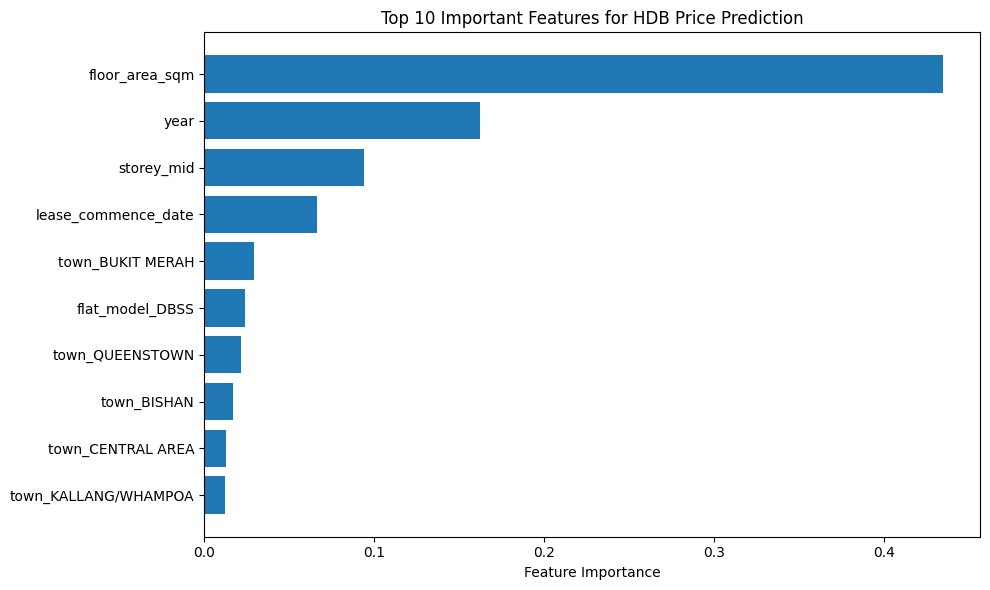

In [ ]:
#Feature importance
import matplotlib.pyplot as plt
import numpy as np

# Extract the trained Random Forest model from the pipeline
rf = rf_pipeline.named_steps['rf']

# Get feature names from the preprocessor
encoded_cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['town', 'flat_type', 'flat_model'])
all_features = list(encoded_cat_features) + ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # Top 10 important features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for HDB Price Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


2. Support Vector Regression (SVM)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import time

# --------- Step 1: Sample the dataset for SVR (SVR is slow on large datasets) ---------
df_sampled = df_cleaned.sample(n=5000, random_state=42)

# --------- Step 2: Select features & target ---------
features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm',
            'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']
target = 'resale_price'

X = df_sampled[features]
y = df_sampled[target]


In [ ]:
# --------- Step 3: Split Data ---------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --------- Step 4: Preprocessing Pipeline ---------
categorical = ['town', 'flat_type', 'flat_model']
numerical = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])


In [ ]:
# --------- Step 5: SVR Model Pipeline ---------
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf', C=1000, epsilon=10000))  # You can tune C and epsilon
])

In [ ]:
# --------- Step 6: Training with Progress Bar ---------
with tqdm(total=1, desc="Training SVR Model", bar_format='{l_bar}{bar}| {elapsed} elapsed') as pbar:
    svr_pipeline.fit(X_train, y_train)
    time.sleep(0.1)
    pbar.update(1)

Training SVR Model: 100%|██████████| 00:01 elapsed


In [ ]:
# --------- Step 7: Evaluation ---------
y_pred = svr_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n SVR RMSE: {rmse:.2f}")
print(f"SVR R² Score: {r2:.4f}")


 SVR RMSE: 118224.87
SVR R² Score: 0.5252


# Extra dataset - Inflation Rate in Singapore

https://www.singstat.gov.sg/find-data/search-by-theme/economy/prices-and-price-indices/latest-data

In [ ]:
import pandas as pd

# Step 1: Load the raw CSV file without skipping rows
raw_cpi = pd.read_csv("M213751 (1).csv", header=None)

# Step 2: Extract headers from row 10 and data from row 11
headers = raw_cpi.iloc[10].tolist()
cpi_values = raw_cpi.iloc[11].tolist()

# Step 3: Clean headers
headers_cleaned = [str(h).strip() for h in headers]

# Step 4: Remove the first non-date header ("Data Series") and align CPI values
valid_months = headers_cleaned[1:]                    # Remove "Data Series"
valid_cpis = cpi_values[1:1 + len(valid_months)]      # Align CPI values

# Step 5: Build clean DataFrame
cpi_df_cleaned = pd.DataFrame({
    'month': valid_months,
    'cpi': valid_cpis
})

# Step 6: Convert types
cpi_df_cleaned['month'] = pd.to_datetime(cpi_df_cleaned['month'], format='%Y %b', errors='coerce')
cpi_df_cleaned['cpi'] = pd.to_numeric(cpi_df_cleaned['cpi'], errors='coerce')

# Step 7: Drop any invalid rows
cpi_df_cleaned = cpi_df_cleaned.dropna(subset=['month', 'cpi'])

# Final CPI output
print(cpi_df_cleaned.head())


       month      cpi
0 2025-02-01  100.677
1 2025-01-01   99.908
2 2024-12-01  100.661
3 2024-11-01  100.387
4 2024-10-01  100.119


Merge with the existing HDB DATASET

In [ ]:
# STEP 1: Ensure 'month' column in HDB dataset is datetime
df_cleaned['month'] = pd.to_datetime(df_cleaned['month'])

# STEP 2: Merge CPI data on 'month'
df_merged = pd.merge(df_cleaned, cpi_df_cleaned, on='month', how='left')

# STEP 3: Inspect merged result
print(df_merged[['month', 'resale_price', 'cpi']].head())


       month  resale_price     cpi
0 2017-01-01      232000.0  85.102
1 2017-01-01      250000.0  85.102
2 2017-01-01      262000.0  85.102
3 2017-01-01      265000.0  85.102
4 2017-01-01      265000.0  85.102


In [ ]:
# Use latest CPI as the base (assumed to be Feb 2025 or Jan 2024)
base_cpi = cpi_df_cleaned['cpi'].iloc[0]  # or .max() if you prefer

# Create inflation-adjusted price column
df_merged['resale_price_real'] = df_merged['resale_price'] * (base_cpi / df_merged['cpi'])

# Preview adjusted prices
df_merged[['resale_price', 'cpi', 'resale_price_real']].head()


,resale_price,cpi,resale_price_real
0,232000.0,85.102,274459.636671
1,250000.0,85.102,295753.918827
2,262000.0,85.102,309950.106931
3,265000.0,85.102,313499.153956
4,265000.0,85.102,313499.153956


In [ ]:
target = 'resale_price_real'


<ipython-input-26-2a0337be6863>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_merged.set_index('month')[['resale_price', 'resale_price_real']].resample('M').mean().plot(figsize=(12, 6))


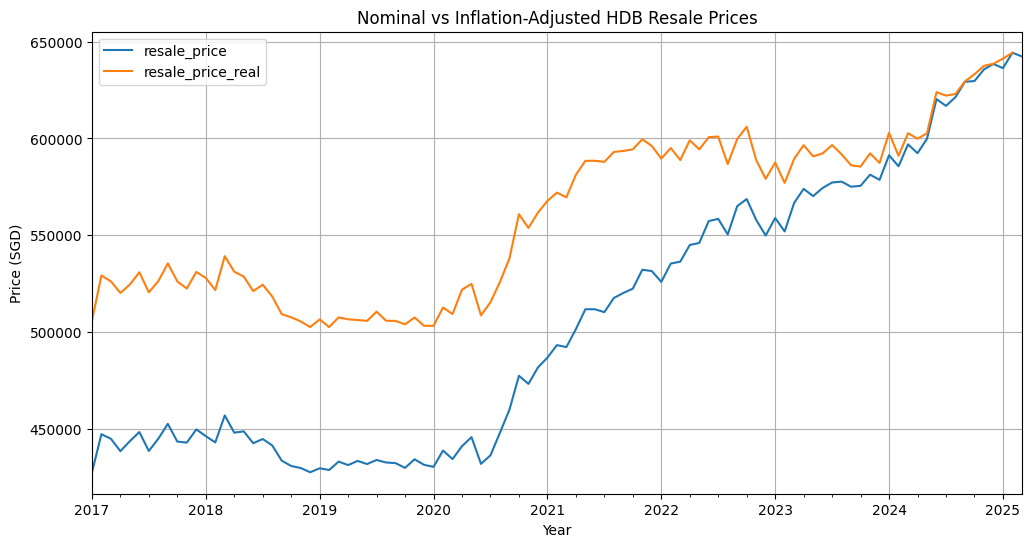

In [ ]:
import matplotlib.pyplot as plt

df_merged.set_index('month')[['resale_price', 'resale_price_real']].resample('M').mean().plot(figsize=(12, 6))
plt.title("Nominal vs Inflation-Adjusted HDB Resale Prices")
plt.ylabel("Price (SGD)")
plt.xlabel("Year")
plt.grid(True)
plt.show()


📈 Key Insights from the Graph
Gap between Nominal and Real Prices (Pre-2022)

From 2017 to ~2021, real prices were significantly higher than nominal.

➤ This shows that earlier flats were cheaper in dollars, but more valuable in today’s terms (after adjusting for inflation).

Convergence in 2024–2025

The two lines almost merge near 2024–2025, which makes sense because your CPI base is from that period.

➤ Inflation adjustment normalizes prices to that year, so nominal ≈ real prices.

Steady Increase in Real Prices from 2020

Real prices also climb from ~2020 onwards, indicating that prices were rising faster than inflation.

➤ This suggests true housing demand or market pressure, not just inflation.

🧠 What You Can Conclude
📌 Inflation plays a huge role in price perception — without adjustment, older flats look artificially cheaper.

📌 Recent price increases (2021–2023) are real, not just inflation-driven.

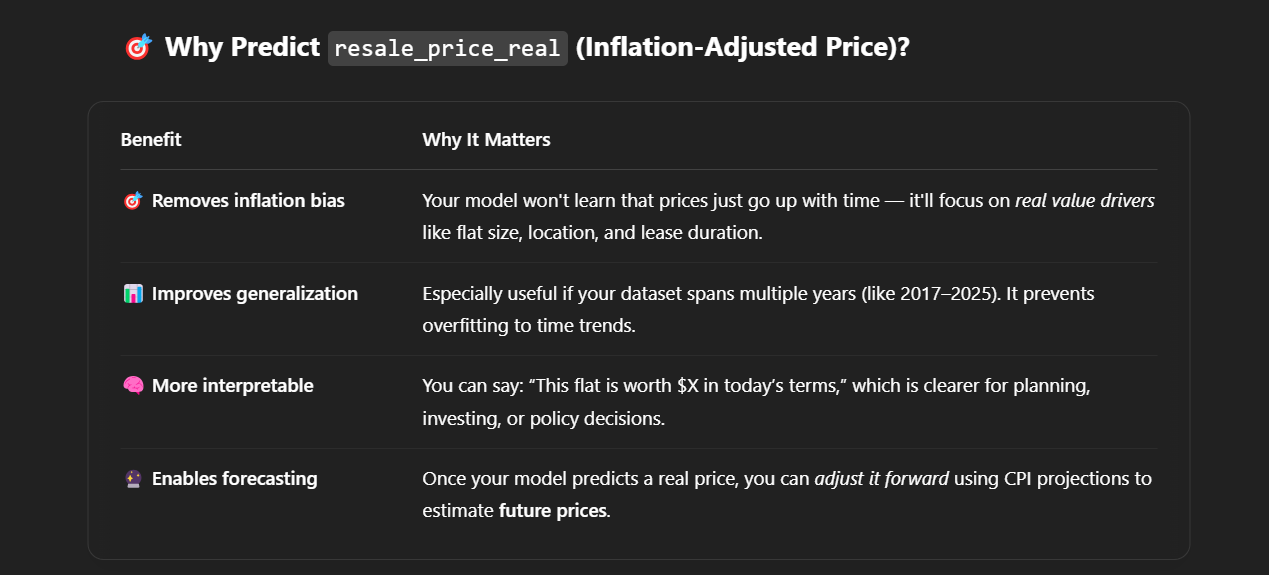

Random Forest Regressor using new target - resale_price_real

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import time

# --------- Step 1: Select Features & New Target ---------
features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm',
            'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']
target = 'resale_price_real'  # use inflation-adjusted price
# Drop rows where resale_price_real is missing
df_merged = df_merged.dropna(subset=['resale_price_real'])

X = df_merged[features]
y = df_merged[target]

# --------- Step 2: Train-Test Split ---------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------- Step 3: Preprocessing ---------
categorical = ['town', 'flat_type', 'flat_model']
numerical = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

# --------- Step 4: Pipeline with Random Forest ---------
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42))
])

# --------- Step 5: Train Model with Progress Bar ---------
with tqdm(total=1, desc="Training Random Forest", bar_format='{l_bar}{bar}| {elapsed} elapsed') as pbar:
    rf_pipeline.fit(X_train, y_train)
    time.sleep(0.1)
    pbar.update(1)


Training Random Forest: 100%|██████████| 04:02 elapsed


In [ ]:
#Model evaluation
# Predict on the test set
y_pred = rf_pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Display results
print(f"\n Random Forest RMSE (Inflation-Adjusted): {rmse:.2f}")
print(f" Random Forest R² Score (Inflation-Adjusted): {r2:.4f}")


 Random Forest RMSE (Inflation-Adjusted): 59004.15
 Random Forest R² Score (Inflation-Adjusted): 0.9015


By using resale_price_real (inflation-adjusted target):

You’ve removed the inflation trend as noise ✅

Your model now focuses on true price drivers like flat type, town, lease, size ✅

The performance still holds up at 90%+ accuracy, showing that your features are doing a great job explaining price ✅

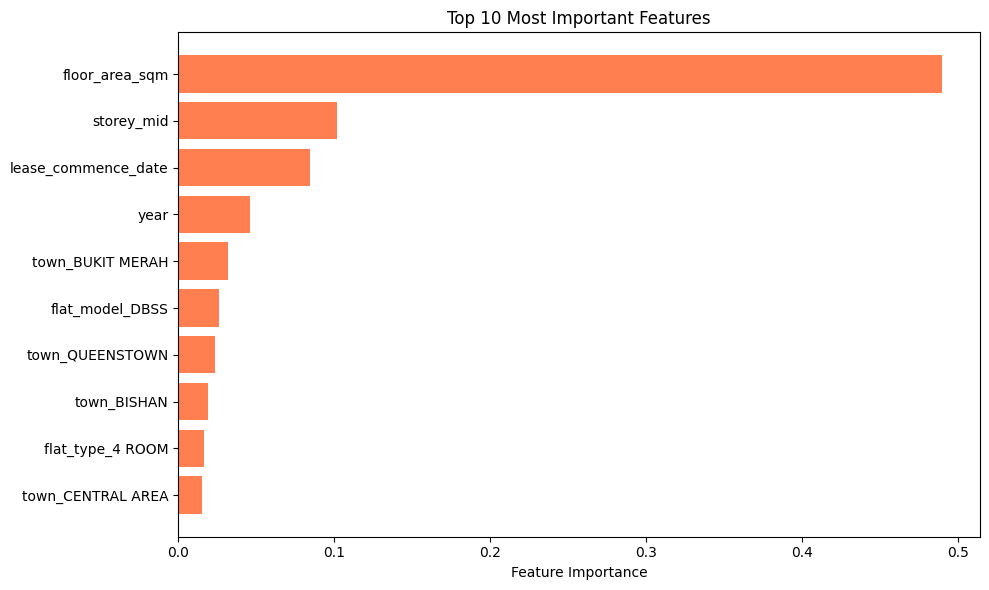

In [ ]:
#Top 10 Feature importance plot
import numpy as np

# Extract the trained Random Forest model
rf_model = rf_pipeline.named_steps['rf']

# Get one-hot encoded feature names from the preprocessor
cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['town', 'flat_type', 'flat_model'])
all_feature_names = list(cat_features) + numerical

# Get feature importances and top 10
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # Top 10 features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center', color='coral')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Predicted vs actual plot

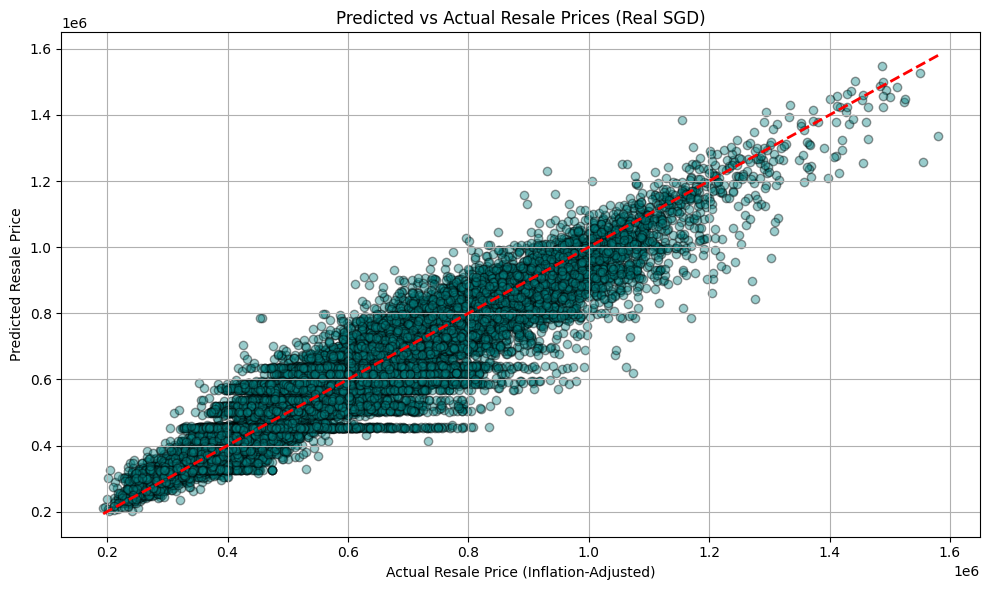

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Price (Inflation-Adjusted)')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Prices (Real SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()


# New Dataset - Amenities


In [ ]:
df_cleaned.to_csv("df_cleaned.csv", index=False)


In [ ]:
import pandas as pd

# Load datasets
df_cleaned = pd.read_csv("df_cleaned.csv")
amenities_df = pd.read_csv("amenities_data.csv")

# Split 'Address' into 'block' and 'street_name'
amenities_df[['block', 'street_name']] = amenities_df['Address'].str.extract(r'^(\d+)\s+(.*)$')

# Convert 'block' to string and clean up any '.0'
df_cleaned['block'] = df_cleaned['block'].astype(str).str.replace(r'\.0$', '', regex=True)
amenities_df['block'] = amenities_df['block'].astype(str)

# Standardize 'street_name' formatting
df_cleaned['street_name'] = df_cleaned['street_name'].str.strip().str.upper()
amenities_df['street_name'] = amenities_df['street_name'].str.strip().str.upper()

# Drop duplicates in amenities to avoid exploding join
amenities_unique = amenities_df.drop_duplicates(subset=['block', 'street_name'])

# Merge on 'block' and 'street_name'
merged_df = pd.merge(df_cleaned, amenities_unique, on=['block', 'street_name'], how='left')

# Optional: Save to CSV
merged_df.to_csv("merged_df_cleaned_with_amenities.csv", index=False)


<ipython-input-12-ec0df8ce7bb0>:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv("df_cleaned.csv")


In [ ]:
merged_df.head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,storey_mid,remaining_lease_years,...,street_name,Address,Address Lat,Address Long,Nearest MRT Station,Nearest MRT Distance,Nearest Mall Name,Nearest Mall Distance,Nearest NPC,Nearest NPC Distance
0,2017-01-01,ANG MO KIO,2 ROOM,44.0,Improved,1979,232000.0,2017,11.0,61.333333,...,ANG MO KIO AVE 10,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION (NS16),1.003997,AMK HUB,1.017286,Bishan Neighbourhood Police Centre,0.829747
1,2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,1978,250000.0,2017,2.0,60.583333,...,ANG MO KIO AVE 4,108 ANG MO KIO AVE 4,1.370966,103.838202,MAYFLOWER MRT STATION (TE6),0.189875,AMK HUB,1.155700,Ang Mo Kio South Neighbourhood Police Centre,1.499927
2,2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,1980,262000.0,2017,2.0,62.416667,...,ANG MO KIO AVE 5,602 ANG MO KIO AVE 5,1.380709,103.835368,LENTOR MRT STATION (TE5),0.535117,AMK HUB,1.925633,Ang Mo Kio North Neighbourhood Police Centre,1.182304
3,2017-01-01,ANG MO KIO,3 ROOM,68.0,New Generation,1980,265000.0,2017,5.0,62.000000,...,ANG MO KIO AVE 10,465 ANG MO KIO AVE 10,1.366201,103.857201,ANG MO KIO MRT STATION (NS16),0.945529,MYVILLAGE AT SERANGOON GARDEN,0.892904,Ang Mo Kio South Neighbourhood Police Centre,0.741873
4,2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,1980,265000.0,2017,2.0,62.416667,...,ANG MO KIO AVE 5,601 ANG MO KIO AVE 5,1.381041,103.835132,LENTOR MRT STATION (TE5),0.501152,AMK HUB,1.969726,Ang Mo Kio North Neighbourhood Police Centre,1.192218


Merged Dataset - Amenities + Original + Inflation

In [ ]:
import pandas as pd
df_merged = pd.read_csv("df_merged.csv")

df_merged.head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,storey_mid,remaining_lease_years,...,Address Lat,Address Long,Nearest MRT Station,Nearest MRT Distance,Nearest Mall Name,Nearest Mall Distance,Nearest NPC,Nearest NPC Distance,cpi,resale_price_real
0,1/1/2017,ANG MO KIO,2 ROOM,44.0,Improved,1979.0,232000.0,2017.0,11.0,61.333333,...,1.362005,103.853880,ANG MO KIO MRT STATION (NS16),1.003997,AMK HUB,1.017286,Bishan Neighbourhood Police Centre,0.829747,85.102,274459.636671
1,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1978.0,250000.0,2017.0,2.0,60.583333,...,1.370966,103.838202,MAYFLOWER MRT STATION (TE6),0.189875,AMK HUB,1.155700,Ang Mo Kio South Neighbourhood Police Centre,1.499927,85.102,295753.918827
2,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1980.0,262000.0,2017.0,2.0,62.416667,...,1.380709,103.835368,LENTOR MRT STATION (TE5),0.535117,AMK HUB,1.925633,Ang Mo Kio North Neighbourhood Police Centre,1.182304,85.102,309950.106931
3,1/1/2017,ANG MO KIO,3 ROOM,68.0,New Generation,1980.0,265000.0,2017.0,5.0,62.000000,...,1.366201,103.857201,ANG MO KIO MRT STATION (NS16),0.945529,MYVILLAGE AT SERANGOON GARDEN,0.892904,Ang Mo Kio South Neighbourhood Police Centre,0.741873,85.102,313499.153956
4,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1980.0,265000.0,2017.0,2.0,62.416667,...,1.381041,103.835132,LENTOR MRT STATION (TE5),0.501152,AMK HUB,1.969726,Ang Mo Kio North Neighbourhood Police Centre,1.192218,85.102,313499.153956


In [ ]:
merged_features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm',
            'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year',
            'Address Lat', 'Address Long', 'Nearest MRT Station', 'Nearest MRT Distance', 'Nearest Mall Name',
            'Nearest Mall Distance', 'Nearest NPC', 'Nearest NPC Distance', 'cpi']
merged_target = 'resale_price_real'

X = df_merged[merged_features]
y = df_merged[merged_target]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

XGBoost

RMSE_XGBoost Regression= 35026.624764748565
R2 Score_XGBoost Regression= 0.9639579824657242


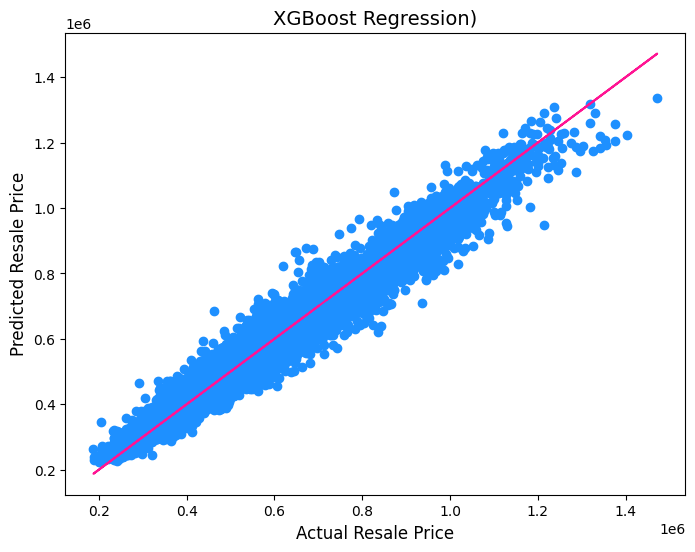

In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data manipulation

# Define categorical and numerical features
categorical_features = ['town', 'flat_type', 'flat_model', 'Nearest MRT Station', 'Nearest Mall Name', 'Nearest NPC']
numerical_features = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year', 'Address Lat', 'Address Long', 'Nearest MRT Distance', 'Nearest Mall Distance', 'Nearest NPC Distance', 'cpi']

# Create a preprocessor for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)]) # sparse=False is important for XGBoost

# Create a pipeline with the preprocessor and XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgbr', xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                             colsample_bytree=1, max_depth=7))
])

# Fit the pipeline to the training data
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the test data
prediction_xgbr = xgb_pipeline.predict(X_test)

# Impute NaN values in y_test (if any) with the mean before evaluation
# This prevents the ValueError
y_test = y_test.fillna(y_test.mean())

# Evaluate the model
print('RMSE_XGBoost Regression=', np.sqrt(metrics.mean_squared_error(y_test, prediction_xgbr)))
print('R2 Score_XGBoost Regression=', metrics.r2_score(y_test, prediction_xgbr))

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=prediction_xgbr, color='dodgerblue')
plt.plot(y_test, y_test, color='deeppink')
plt.xlabel('Actual Resale Price', fontsize=12)
plt.ylabel('Predicted Resale Price', fontsize=12)
plt.title('XGBoost Regression)', fontsize=14)
plt.show()

Correlation of features with Price

In [ ]:
# Convert 'month' to numerical representation (e.g., ordinal) before calculating correlation.
df_merged['month'] = pd.to_datetime(df_merged['month'])

# Now apply the toordinal function
df_merged['month_ordinal'] = df_merged['month'].apply(lambda date: date.toordinal())

# Select only numerical features for correlation calculation
numerical_features = df_merged.select_dtypes(include=['number']).columns
correlation = df_merged[numerical_features].drop(columns=['month_ordinal']).corr()  # Exclude month_ordinal if you don't want its correlation

# Now you can access and sort correlations with 'resale_price_real'
correlation['resale_price_real'].sort_values(ascending=False).drop('resale_price_real')

,resale_price_real
resale_price,0.999840
floor_area_sqm,0.630162
storey_mid,0.370419
lease_commence_date,0.332857
remaining_lease_years,0.331694
Address Long,0.115890
year,0.034050
cpi,0.026166
Nearest NPC Distance,-0.083939
Nearest MRT Distance,-0.125051


In [ ]:
corr = correlation['resale_price_real'].sort_values(ascending=False).drop('resale_price_real')

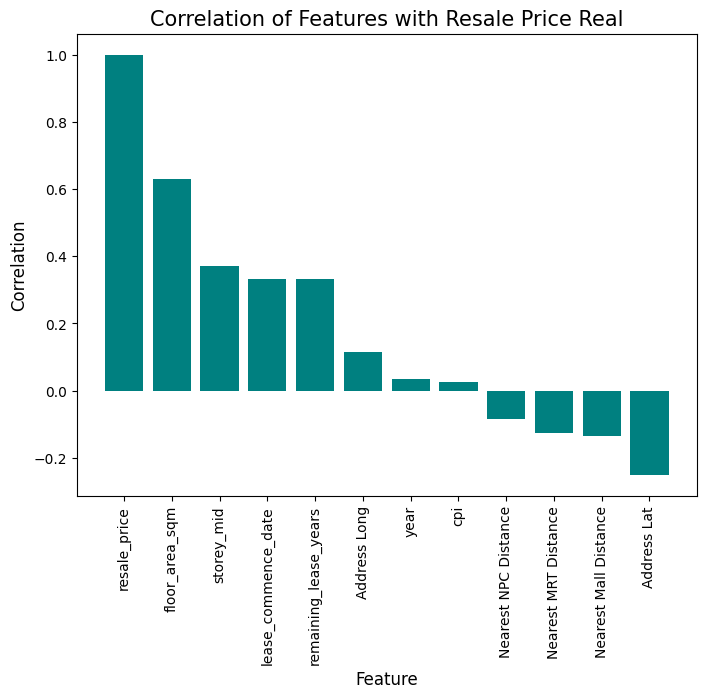

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(x=list(corr.index), height=list(corr.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Resale Price Real', fontsize=15)
plt.show()


# Amenities + Inflation Rate

Data preprocessing

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --------------------------
# STEP 1: Load and Preprocess Dataset
# --------------------------

# Load the dataset
df = pd.read_csv("df_merged.csv")

# Convert 'month' to datetime
df['month'] = pd.to_datetime(df['month'], errors='coerce')

# Drop unnecessary text fields for modeling
df = df.drop(columns=['Address', 'Nearest MRT Station', 'Nearest Mall Name', 'Nearest NPC'])

# Drop any rows with missing resale_price_real or CPI
df = df.dropna(subset=['resale_price_real', 'cpi'])

# --------------------------
# STEP 2: Define Features and Target
# --------------------------

features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'lease_commence_date',
            'remaining_lease_years', 'storey_mid', 'year', 'Nearest MRT Distance',
            'Nearest Mall Distance', 'Nearest NPC Distance', 'cpi', 'Address Lat', 'Address Long']
target = 'resale_price_real'

X = df[features]
y = df[target]

# --------------------------
# STEP 3: Train-Test Split
# --------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [ ]:
# --------------------------
# STEP 4: Preprocessing and Random Forest Pipeline
# --------------------------

categorical = ['town', 'flat_type', 'flat_model']
numerical = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42))
])


In [ ]:
# --------------------------
# STEP 5: Model Training
# --------------------------

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)




In [ ]:
# Calculate RMSE manually
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Print results
print(f"RMSE (Inflation+Amenities): {rmse:.2f}")
print(f"R² Score (Inflation+Amenities): {r2:.4f}")

RMSE (Inflation+Amenities): 34729.36
R² Score (Inflation+Amenities): 0.9657


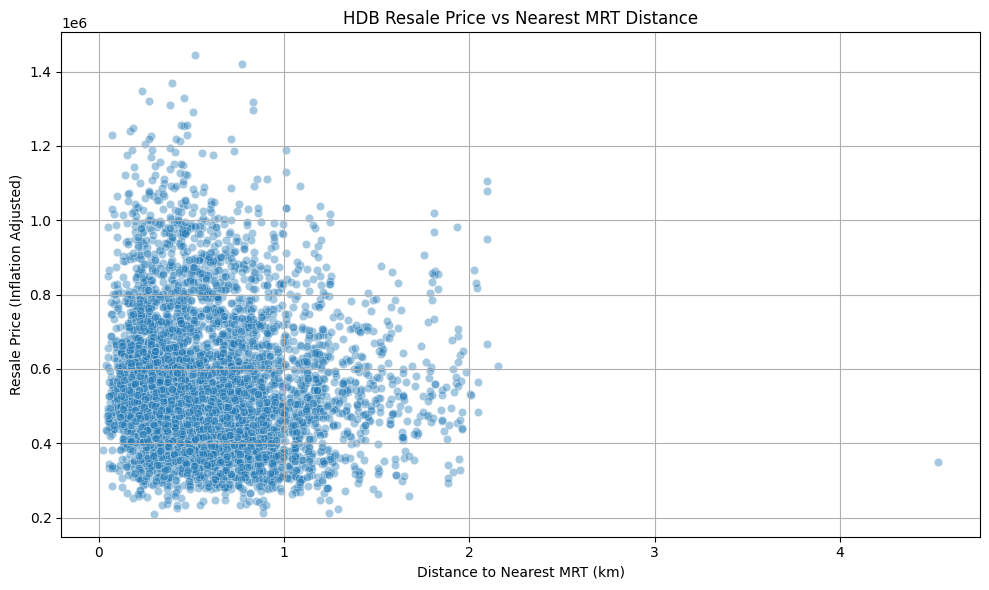

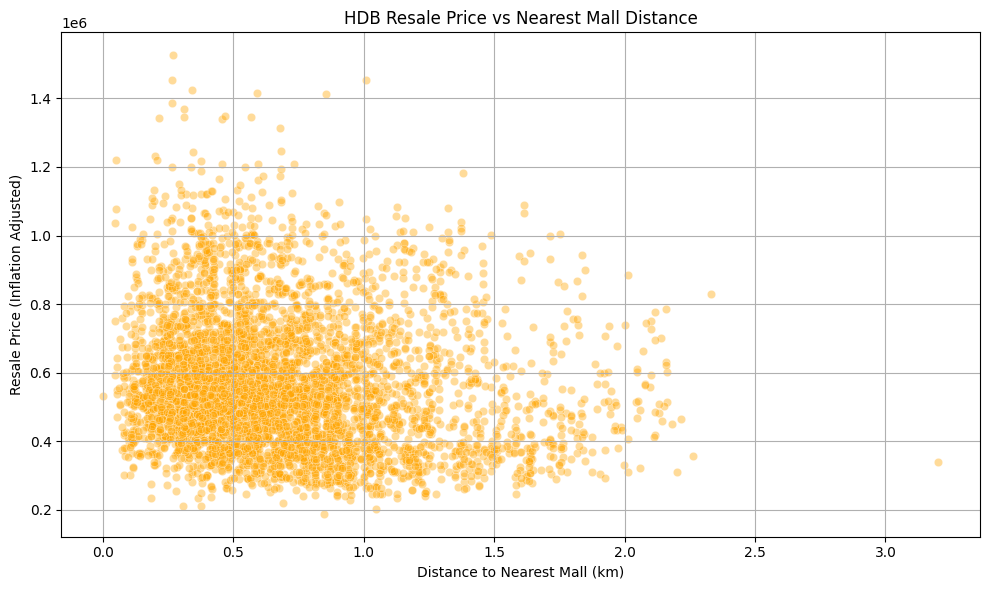

(np.float64(34729.35717536194), 0.9657332712843137)

In [ ]:

# --------------------------
# STEP 6: Amenity Visualizations
# --------------------------

# Visualization 1: Resale price vs MRT distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(5000), x='Nearest MRT Distance', y='resale_price_real', alpha=0.4)
plt.title('HDB Resale Price vs Nearest MRT Distance')
plt.xlabel('Distance to Nearest MRT (km)')
plt.ylabel('Resale Price (Inflation Adjusted)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization 2: Resale price vs Mall distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(5000), x='Nearest Mall Distance', y='resale_price_real', alpha=0.4, color='orange')
plt.title('HDB Resale Price vs Nearest Mall Distance')
plt.xlabel('Distance to Nearest Mall (km)')
plt.ylabel('Resale Price (Inflation Adjusted)')
plt.grid(True)
plt.tight_layout()
plt.show()

rmse, r2


<ipython-input-9-3221ceee966c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='MRT_Distance_Bin', y='resale_price_real', palette='Set2')


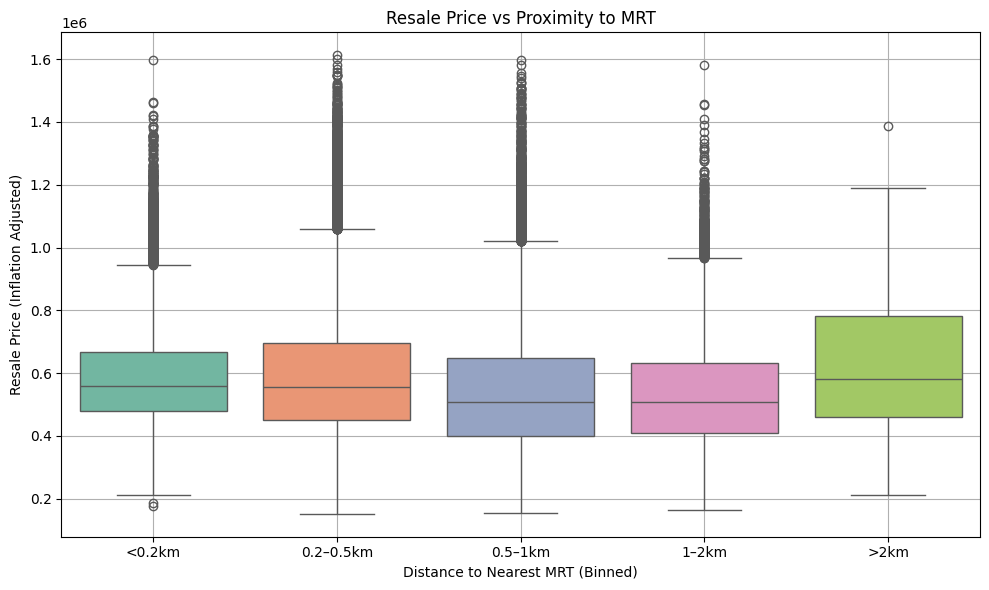

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Bin MRT distances (e.g., <0.2 km, 0.2–0.5 km, etc.)
df['MRT_Distance_Bin'] = pd.cut(df['Nearest MRT Distance'],
                                bins=[0, 0.2, 0.5, 1.0, 2.0, 5.0],
                                labels=['<0.2km', '0.2–0.5km', '0.5–1km', '1–2km', '>2km'])

# Boxplot of resale prices by MRT distance bin
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='MRT_Distance_Bin', y='resale_price_real', palette='Set2')
plt.title('Resale Price vs Proximity to MRT')
plt.xlabel('Distance to Nearest MRT (Binned)')
plt.ylabel('Resale Price (Inflation Adjusted)')
plt.grid(True)
plt.tight_layout()
plt.show()
